# Abstract 

The work presented here uses motion data from waist mounted smartphones in an effort to build a model that predicts that type of physical activity being performed by the user. The study that collected the data had 30 participants aged 17-49 perform six different activities while the smartphone recorded data using its embedded accelerometer and gyroscope. The result is a dataset that contains over 500 feature variables, providing different information about the speed, angle, and direction of the smartphone while it is connected to the participant's waist as they perform the different activities. We show that the user activity can be accuractely predicted by means of a random forest classification model, which, after hyperparameter tuning, achieved a weighted average F1 score of ~90% on a testing set, even after a principal component analysis that removed half of the original features. In addition, with the exception of very few test cases, misclassifications are entirely contained within two groups in which the model only mistook "inactive" activities for other "inactive" activities, and "active" activities for other "active" activities (i.e. sitting being mistaken as lying down, or walking upstairs being mistaken with walking).

# Setup/Imports 

The cell below includes all the imports needed to run this notebook. It also defines a seed number (stored in the variable `rs`) that can be used for the purpose of reproducability. 

In [1]:
# essential imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import re
import time

# sklearn imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from scipy import linalg

# define random state
rs = 42

# Introduction/Data Import

The advent of smart phones and smart watches has revolutionized how millions of people approach health and fitness, as these devices can be used to track almost every aspect of your physical motion, even while you sleep. Phones are able to recognize a multitide of different physical activites from running, walking sitting, etc. by using data from various accelerometers and gyroscopes, which measure the speed, angle, and direction of your device as it is connected to you. But how does it actually go about making the determination of the activity you're partaking in? The work presented here uses smartphone motion data to in an attempt to build a model showing how this can be done.

The data for this project comes from [Kaggle](https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones) and was collected via sensors from waist-mounted smartphones as study participants performed six different physical activities: running, walking, sitting, laying down, walking upstairs, and walking downstairs. A more detailed description of the data collection process is provided in [this 2013 paper](https://www.esann.org/sites/default/files/proceedings/legacy/es2013-84.pdf). 

The data on Kaggle is already separated into testing and training datasets, which are imported in the cell below:

In [2]:
train_df = pd.read_csv('Data/train.csv')
test_df = pd.read_csv('Data/test.csv')
print(train_df.shape)
print(test_df.shape)
print(test_df.shape[0] / (train_df.shape[0] + test_df.shape[0]))

(7352, 563)
(2947, 563)
0.28614428585299545


We see that both the testing and training set contain 563 features, with 2,947 and 7,352 observations, respectively. As such, the testing dataset makes up about 28% of the total observations.

# Data Cleaning

Before performing any analysis using our data, the cells in this section peform various data quality checks to ensure  that the dataset contains high quality, clean data. First, the cell below checks if there are null/empty values in any of the fields of our dataset:

In [3]:
train_df.isnull().any().value_counts()

False    563
dtype: int64

The `False` above indicates that no null values could be found in a column, and we see that this is indeed the case for all 563 of them. The cell below performs a similar check, but this time checking for any `NaN` values:

In [4]:
train_df.isna().any().value_counts()

False    563
dtype: int64

Once again, the above output shows that none of the columns contain a `NaN` value. 

Next, cell below checks the `dtype` of all the columns in the dataframe to get a better idea of the breakdown between categorical, and numeric fields in the dataset:

In [5]:
train_df.dtypes.value_counts()

float64    561
int64        1
object       1
dtype: int64

As we can see from the output above, all but two of the training dataset's columns are floating point fields, which warrants further investigation. First, the cell below identifies the single `int64` field:

In [6]:
train_df.select_dtypes(include=[np.int64]).columns

Index(['subject'], dtype='object')

Thus, `Subject` is the single integer field in question. If we look at all the unique values in `Subject`:

In [7]:
train_df['subject'].value_counts().sort_index()

1     347
3     341
5     302
6     325
7     308
8     281
11    316
14    323
15    328
16    366
17    368
19    360
21    408
22    321
23    372
25    409
26    392
27    376
28    382
29    344
30    383
Name: subject, dtype: int64

We see that this field is simply made up a list of numbers 1-30, which can be explained via the following description of the experiment on [Kaggle](https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones): "The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years." Thus, this column is simply an id field that corresponds to each of the study's participants, and as such provides no predictive value. It is removed from the training and testing datasets in the cell below:

In [8]:
train_df = train_df.drop(columns='subject')
test_df = test_df.drop(columns='subject')

In a similar manner, we can identify the name of the single `object` field in the dataframe:

In [9]:
train_df.select_dtypes(include=[object]).columns

Index(['Activity'], dtype='object')

The `Activity` field is our target variable, and as such should be removed, but stored in a separate place to for later model fitting and prediction. As a final data cleaning step, the cell below removes the `Activity` field from the training and testing datasets, and stores them in separate arrays to be used later.

In [10]:
y_train = train_df['Activity'].values
y_test = test_df['Activity'].values

train_df = train_df.drop(columns ='Activity')
test_df = test_df.drop(columns ='Activity')

train_df.shape

(7352, 561)

We see from the above that our training dataset has reached a final structure that contains 7,352 observations of 561 explanatory fields, and the target variable has been stored in the arrays `y_train` and `y_test`. 

Though the data provided is clearly already of high quality, the above data quality checks provide confidence that we are working with a clean dataset ready for analysis. 

# Exploratory Data Analysis

This section is devoted to getting a better understanding of the information stored within our dataset, by analyzing various facets of the target and explanatory variables. 

## Target Variable

First, the cell below creates a dataframe `target_counts`, that counts the instances of each class of the target variable: 

In [11]:
target_counts = pd.DataFrame(np.transpose(np.unique(y_train, return_counts=True)))
target_counts.columns = ['Activity', 'count']
target_counts = target_counts.sort_values(by='count')
target_counts

,Activity,count
4,WALKING_DOWNSTAIRS,986
5,WALKING_UPSTAIRS,1073
3,WALKING,1226
1,SITTING,1286
2,STANDING,1374
0,LAYING,1407


The classes appear reasonably balanced, though there is a not insignificant difference between the number of observations of the most populous class (`LAYING`) and the least populous class (`WALKING_DOWNSTAIRS`). The cell below produces a bar plot of the above data to get a better idea of the differences between these class counts:

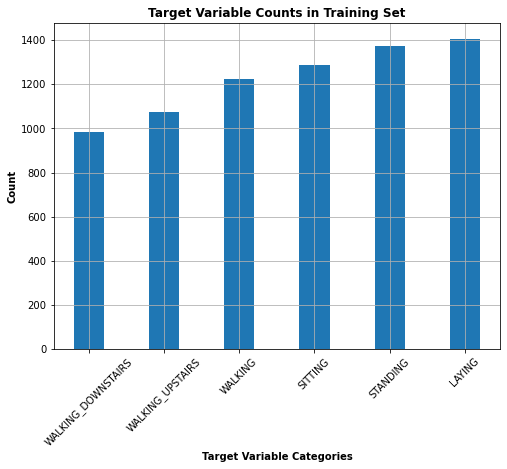

In [12]:
plt.figure(figsize=(8,6))
plt.bar(target_counts['Activity'], target_counts['count'], width = 0.4)
plt.xlabel('Target Variable Categories', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('Target Variable Counts in Training Set', fontweight='bold')
plt.xticks(rotation = 45) 
plt.grid()
plt.show()

Identifying the fact that the classes are unbalanced will be important when it comes to later modelling steps. 

## Explanatory Fields

Because there are a total of 561 predictor fields in our dataset, it is close to impossible to explore and evaluate each of them individually. However, we can still implement a number of methods to explore the fields as a collction. For example, the cell below provides a distribution of the variance of the predictor fields:

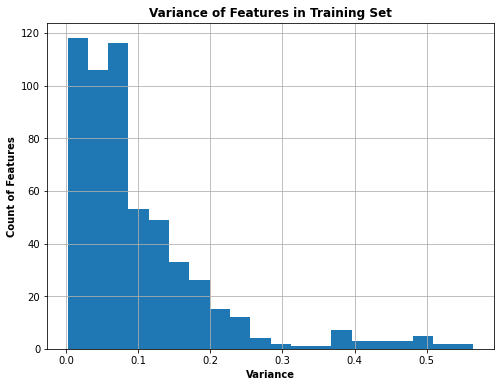

In [13]:
feature_vars = train_df.var(axis=0)
feature_vars = feature_vars[::-1]

plt.figure(figsize=(8,6))

plt.hist(feature_vars, bins=20)
plt.xlabel('Variance', fontweight='bold')
plt.ylabel('Count of Features', fontweight='bold')
plt.title('Variance of Features in Training Set', fontweight='bold')
plt.grid()
plt.show()

The cell below performs the same for the means of the predictor variables:

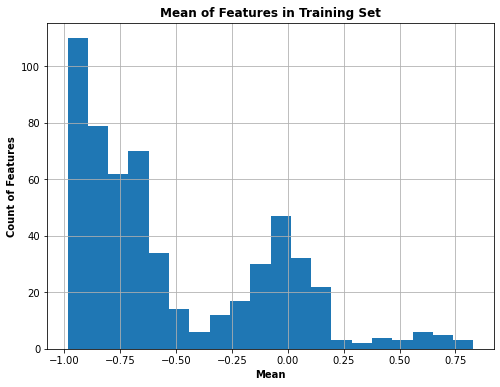

In [14]:
feature_means = train_df.mean(axis=0)
feature_means = feature_means[::-1]

plt.figure(figsize=(8,6))

plt.hist(feature_means, bins=20)
plt.xlabel('Mean', fontweight='bold')
plt.ylabel('Count of Features', fontweight='bold')
plt.title('Mean of Features in Training Set', fontweight='bold')
plt.grid()
plt.show()

Lastly, we repeat the same process for the medians of the explanatory fields:

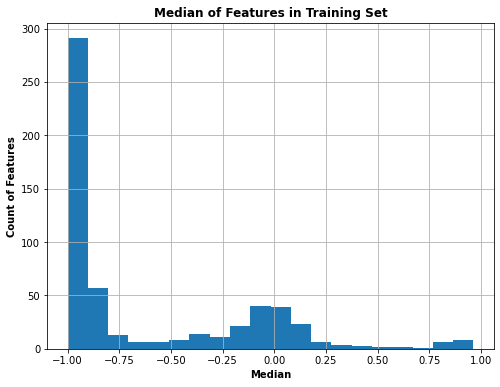

In [15]:
feature_meds = train_df.median(axis=0)
feature_meds = feature_meds[::-1]

plt.figure(figsize=(8,6))

plt.hist(feature_meds, bins=20)
plt.xlabel('Median', fontweight='bold')
plt.ylabel('Count of Features', fontweight='bold')
plt.title('Median of Features in Training Set', fontweight='bold')
plt.grid()
plt.show()

We see that while the spread in varianaces and means across the predictor variables is not huge, the distribtions indicate that are clear differences and even possibly some groupings of different variables. For example, the distribution of means shows that there's a clear grouping of fields with means between -1.00-0.50 and -0.25-0.25. The cell below separates these groupings in an effort to understand if there is an underlying difference between the two:

In [16]:
g1 = list(feature_means[feature_means < -0.5].index)
g2 = list(feature_means[(feature_means > -0.25) & (feature_means < 0.25)].index)

r = re.compile("^(.+?)(-|\()") # regex to simplify column names
g1 = set([r.search(name).group(1) for name in g1])
g2 = set([r.search(name).group(1) for name in g2])

print(g1, '\n', g2)

{'fBodyBodyAccJerkMag', 'fBodyAcc', 'tBodyAccJerkMag', 'fBodyAccJerk', 'fBodyBodyGyroMag', 'tBodyGyroMag', 'tBodyAccMag', 'tGravityAcc', 'tBodyAcc', 'tBodyAccJerk', 'tBodyGyroJerk', 'tBodyGyro', 'tBodyGyroJerkMag', 'fBodyAccMag', 'tGravityAccMag', 'fBodyGyro', 'fBodyBodyGyroJerkMag'} 
 {'fBodyBodyAccJerkMag', 'fBodyAcc', 'tBodyAccJerkMag', 'fBodyAccJerk', 'fBodyBodyGyroMag', 'tBodyGyroMag', 'tBodyAccMag', 'tGravityAcc', 'tBodyAcc', 'tBodyAccJerk', 'tBodyGyroJerk', 'tBodyGyro', 'tBodyGyroJerkMag', 'fBodyAccMag', 'angle', 'fBodyGyro', 'tGravityAccMag', 'fBodyBodyGyroJerkMag'}


We see in the above printout the unique parts of the beginning of each field name in either group. Unfortunately, the two groupings are almost exactly the same, and it appears there are just to many variables to discern any meaningful difference between the two groups using this method. 

The same is true when attempting to look as the apparent groupings in the median, in which over half of the features appear to have medians close to 1. 

In [17]:
g1 = list(feature_meds[feature_means < -0.9].index)
g2 = list(feature_meds[(feature_means > -0.5)].index)

r = re.compile("^(.+?)(-|\()") # regex to simplify column names
g1 = set([r.search(name).group(1) for name in g1])
g2 = set([r.search(name).group(1) for name in g2])

print(g1, '\n', g2)

{'fBodyAcc', 'fBodyAccJerk', 'tBodyAcc', 'tGravityAcc', 'tBodyAccJerk', 'tBodyGyro', 'tBodyGyroJerkMag', 'tBodyGyroJerk', 'fBodyGyro', 'fBodyBodyGyroJerkMag'} 
 {'fBodyBodyAccJerkMag', 'fBodyAcc', 'tBodyAccJerkMag', 'fBodyAccJerk', 'fBodyBodyGyroMag', 'tBodyGyroMag', 'tBodyAccMag', 'tGravityAcc', 'tBodyAcc', 'tBodyAccJerk', 'tBodyGyroJerk', 'tBodyGyro', 'tBodyGyroJerkMag', 'fBodyAccMag', 'angle', 'fBodyGyro', 'tGravityAccMag', 'fBodyBodyGyroJerkMag'}


Because there are so many features, there is a high probability for collinearity in this dataset. The cell below plots the distribution of correlation values within the dataset:

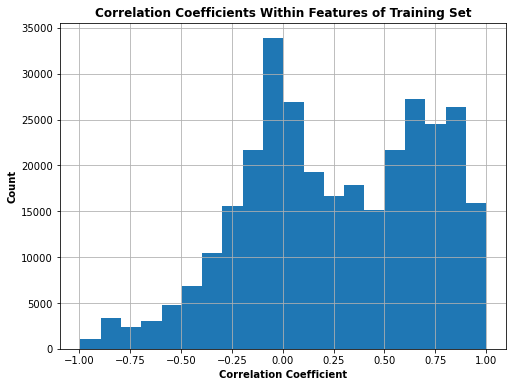

In [18]:
corr_df = train_df.corr()
corr_mat = corr_df.values
corr_list = corr_mat.ravel().tolist()

plt.figure(figsize=(8,6))

plt.hist(corr_list, bins=20)
plt.xlabel('Correlation Coefficient', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('Correlation Coefficients Within Features of Training Set', fontweight='bold')
plt.grid()
plt.show()

We see that while a majority of the correlation coefficients fall between -0.25 and 0.25, there are a large number that have strong correlations greater than 0.5. However, a better method of determining the collinearity between features in a dataset is to evaluate variance inflation factors (VIFs). A single VIF can be calculated for each feature, and a general rule of thumb when interpreting them is as follows:

* VIF < 1: not correlated.
* VIF between 1 and 5: = moderately correlated.
* VIF > 5 = highly correlated.

VIF values for all features in a dataset can be found by taking the inverse of the correlation matrix (to generate the precision matrix), and stripping out the diagonal:

In [19]:
precision_mat = np.linalg.pinv(corr_mat)
vifs = np.diag(precision_mat)

The distribution of VIF values is plotted below:

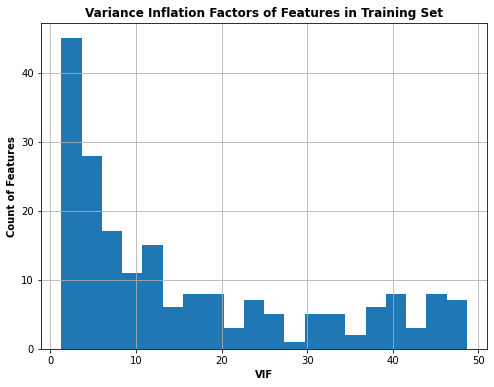

In [20]:
plt.figure(figsize=(8,6))

plt.hist(vifs[vifs < 50], bins=20)
plt.xlabel('VIF', fontweight='bold')
plt.ylabel('Count of Features', fontweight='bold')
plt.title('Variance Inflation Factors of Features in Training Set', fontweight='bold')
plt.grid()
plt.show()

As we can see from the image above, there are a number of features with very high VIF values (even past a VIF of 50, as this was only the histogram cutoff). The analysis of the correlations and VIFs indicate that this dataset could likely benefit from dimensionality reduction when we begin modelling, as many of the features seem to be repeated information. 

# Modelling 

Now that we've had a chance to take a look at our data, the work of this section will be to attempt to build a model that accuractely predicts the classes of the target variable. 

## Scaling

In the previous section, our data was shown to have a range of variances and means across fields. As such, it is imperative that we scale the features in our dataset so that they all contribute equally to the fitting of any classification model. The cell below uses `sklearn`'s `StandardScaler` so that the mean $\mu$ and standard deviation $\sigma$ of each field in the training set will be 0 and 1, respectively. It also uses the scaler's fit of the training data to transform the test data. 

In [21]:
feature_names = train_df.columns
scaler = StandardScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df.values), columns=feature_names)
test_df = pd.DataFrame(scaler.transform(test_df.values), columns=feature_names)
X_train = train_df.values
X_test = test_df.values

## KNN-Model

To test the feasability of building a predictive model using this dataset, we will first implement a K-Nearest Neighbors (KNN) model. KNN is a arguably the [simplest machine learning algorithm](https://medium.com/swlh/k-nearest-neighbor-ca2593d7a3c4), and as such can be used to get a reasonable benchmark when evaluating the performance of more complex models. It also has the benefit of being quick to train and give predictions. The cell below fits an out-of-the-box KNN classifier uses the training data to make predictions on the test data: 

In [22]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
preds = knn.predict(X_test)

We can see how well the model performed by printing out a confusion matrix and classification report:

                    precision    recall  f1-score   support

            LAYING       0.99      0.96      0.98       537
           SITTING       0.88      0.76      0.82       491
          STANDING       0.80      0.93      0.86       532
           WALKING       0.82      0.97      0.89       496
WALKING_DOWNSTAIRS       0.95      0.75      0.84       420
  WALKING_UPSTAIRS       0.90      0.89      0.89       471

          accuracy                           0.88      2947
         macro avg       0.89      0.88      0.88      2947
      weighted avg       0.89      0.88      0.88      2947



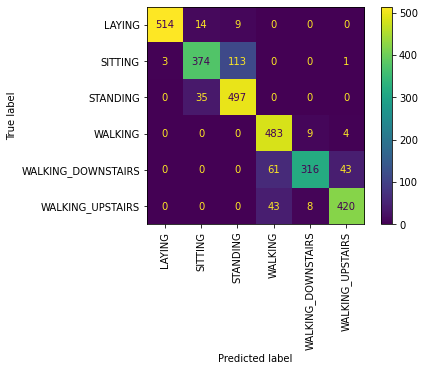

In [23]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(xticks_rotation=90)
print(classification_report(y_test, preds))

As is clear in the cell above, this out-of-the-box, simple machine learning model is already doing quite a great job! The precision and recall (and as a result, the F1 score) for each of the classes, and their overall/weighted average is quite high. Additionally, we can see in the confusion matrix that the misclassifications are due to the model confusing "activities" that are similar to one another: the model only made mistakes within a `LAYING`, `SITTING`, and `STANDING` "inactive" group and a `WALKING`, `WALKING_DOWNSTAIRS`, and `WALKING_UPSTAIRS` "active" group (with the exception of one `SITTING` observation that was predicted as `WALKING_UPSTAIRS`. 

We can attempt to improve the model's performance by modifying the `n_neighbors` parameter in the KNN model. The cell below creates KNN models using between 1-15 neighbors, and determines the weighted average f1 score (across all classes) when making predictions on the training and test sets:  

In [24]:
neighbors = np.arange(1, 15)

# intialize empty list for scores
train_scores = []
test_scores = []

# loop through neigbors, fit model for each neighbor value and get score on tesing and training set
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_train)
    cr = classification_report(y_train, preds, output_dict=True)
    macro_f1 = cr['weighted avg']['f1-score']
    train_scores.append(macro_f1)
    preds = knn.predict(X_test)
    cr = classification_report(y_test, preds, output_dict=True)
    macro_f1 = cr['weighted avg']['f1-score']
    test_scores.append(macro_f1)

The cell below plots the results:

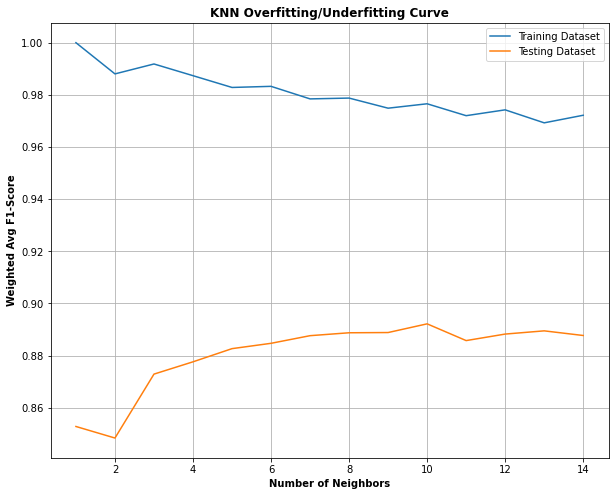

In [25]:
plt.figure(figsize=(10, 8))
plt.plot(neighbors, train_scores, label = 'Training Dataset')
plt.plot(neighbors, test_scores, label = 'Testing Dataset')
plt.xlabel('Number of Neighbors', fontweight = 'bold')
plt.ylabel('Weighted Avg F1-Score', fontweight = 'bold')
plt.title('KNN Overfitting/Underfitting Curve', fontweight='bold')
plt.legend()
plt.grid()
plt.show()

It appears as though 10 neighbors is the ideal value of `n_neighbors` when building the KNN model. Indeed, we do see a slight improvement in performance from the out of the box model if we create new a new confusion matrix and classification report: 

                    precision    recall  f1-score   support

            LAYING       0.99      0.96      0.97       537
           SITTING       0.89      0.82      0.86       491
          STANDING       0.84      0.93      0.88       532
           WALKING       0.82      0.98      0.89       496
WALKING_DOWNSTAIRS       0.98      0.75      0.85       420
  WALKING_UPSTAIRS       0.89      0.89      0.89       471

          accuracy                           0.89      2947
         macro avg       0.90      0.89      0.89      2947
      weighted avg       0.90      0.89      0.89      2947



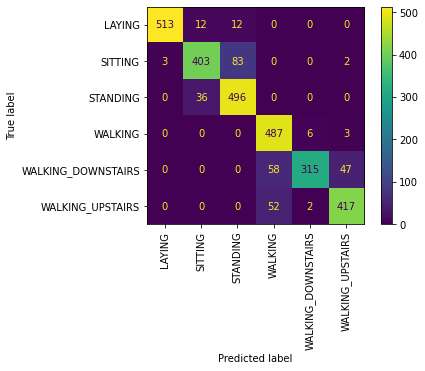

In [26]:
knn = KNeighborsClassifier(n_neighbors=10)
start_time = time.time()
knn.fit(X_train, y_train)
knn_fit_time = time.time() - start_time
preds = knn.predict(X_test)

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(xticks_rotation=90)
print(classification_report(y_test, preds))

As this simple model already seems to hold a lot of predictive power, it should hopefully be the case that more complex models provide even better results. 

## Random Forest Classifier

[Rnadom Forests](https://medium.com/analytics-vidhya/data-science-random-forest-6f82577be93c#:~:text=Random%20Forest%20is%20an%20supervised,produce%20one%20optimal%20predictive%20model) (RFs) are a commonly used machine learning algorithm for classification (though they can also be modified to solve regression problems), and make use of a collection of descision trees to help make predictions on datasets with two or more classes. RFs have much more complexity, as well as an added number of hyperparameters that can be tuned to to modify performance, and as such should hopefully perform better than our KNN-model. First, however, the cell below creates an out-of-the-box random forest classifier to test and see what we can expect from the model:

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.91      0.89      0.90       491
          STANDING       0.90      0.92      0.91       532
           WALKING       0.90      0.97      0.93       496
WALKING_DOWNSTAIRS       0.96      0.85      0.90       420
  WALKING_UPSTAIRS       0.89      0.91      0.90       471

          accuracy                           0.92      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.92      0.92      2947



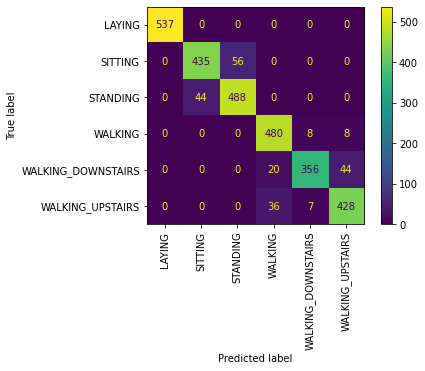

In [27]:
start_time = time.time()
rf = RandomForestClassifier(class_weight='balanced')
start_time = time.time()
rf.fit(X_train, y_train)
rf_fit_time = time.time() - start_time
preds = rf.predict(X_test)

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(xticks_rotation=90)
print(classification_report(y_test, preds))

We see already that this out-of-the-box RF model performs better than the tuned KNN model: there is still some misclassification within the "active" and "inactive" groupings, but overall average precision, recall, and F1 score have increased for all classes. 

However, with this increased accuracy comes a tradeoff: the cell below compares the amount it time it took to train both the KNN and RF models:

In [28]:
print('KNN fit time: %f' %knn_fit_time)
print(' RF fit time: %f' %rf_fit_time)
print('Factor Difference %f' %(rf_fit_time / knn_fit_time))

KNN fit time: 0.009314
 RF fit time: 9.443211
Factor Difference 1013.892154


As we can see from the above, the RF model took almost 700 times longer to train than the KNN model. If this model were ever to be implemented in the real world this increased amount of time could cause issues as the the number of observations in the dataset grows. In addition, it will be inefficient to test different RF models when we eventually attempt hyperparameter tuning. 

However, to get around this we can attempt to reduce the number of features in our dataset, which already seemed like a beneficial idea given the analysis in the previous section. The cell below shows how the time to train the model changes as we change the number of features (features were chosen randomnly for each datapoint):

In [29]:
df_sizes = np.arange(10, 561, 50)
rf_fit_times = []

for df_size in df_sizes:
    tmp_X_train = train_df.sample(n=df_size,axis='columns',replace=True).values
    start_time = time.time()
    rf.fit(tmp_X_train, y_train)
    rf_fit_time = time.time() - start_time
    rf_fit_times.append(rf_fit_time)

The results are plotted below:

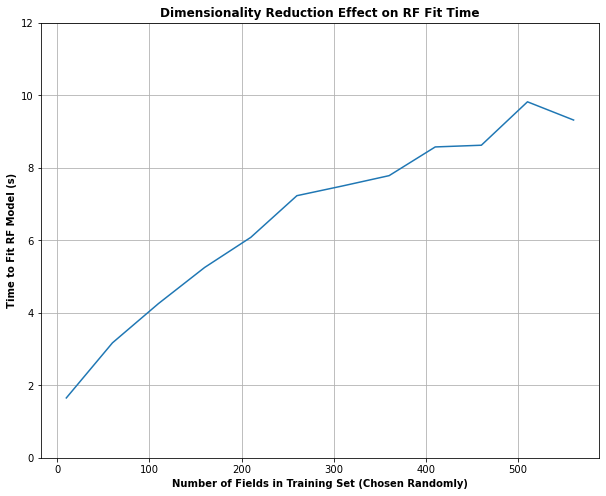

In [30]:
plt.figure(figsize=(10,8))

plt.plot(df_sizes, rf_fit_times)
plt.xlabel('Number of Fields in Training Set (Chosen Randomly)', fontweight='bold')
plt.ylabel('Time to Fit RF Model (s)', fontweight='bold')
plt.title('Dimensionality Reduction Effect on RF Fit Time', fontweight='bold')
plt.ylim(0, 12)
plt.grid()
plt.show()

## Dimensionality Reduction

The previous subsection provided evidence that a RF model is likely a great choice for this dataset, but also showed it would be worthwhile to attempt some dimensionality reduction before moving on with fine-tuning it. In order to figure out which fields that we can remove that will have the least impact on the model's performance, we can perform a principal component analysis (PCA). [PCA is method of dimensionality reduction](https://towardsdatascience.com/principal-component-analysis-pca-explained-visually-with-zero-math-1cbf392b9e7d) that analyzes the variance of the different fields of a dataset in an attempt to keep those which are the most "useful".

PCA computes what's known as a "explained variance ratio" for each principal component in a dataset, which is used to then select the features that stay and go. The higher the "explained variance ratio", the more useful the component is in the dataset. The cell below performs a PCA to get the distribution of explained variance ratios for all features:

In [31]:
pca = PCA(n_components = X_train.shape[1])
pca.fit(X_train)
explained_variance = pca.explained_variance_
explained_variance_ratio = explained_variance / sum(explained_variance)

The results are plotted in the cell below:

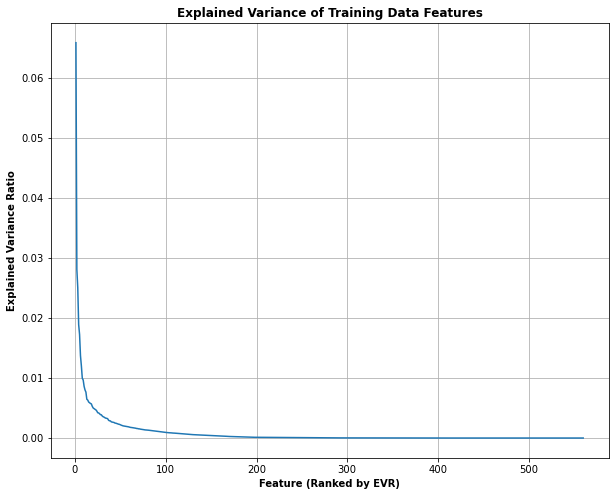

In [32]:
plt.figure(figsize=(10,8))

plt.plot(np.arange(1, 561, 1), explained_variance_ratio[1:])
plt.xlabel('Feature (Ranked by EVR)', fontweight='bold')
plt.ylabel('Explained Variance Ratio', fontweight='bold')
plt.title('Explained Variance of Training Data Features', fontweight='bold')
plt.grid()
plt.show()

As is clear from the graph above, the vast majority of features do not seem to be contributing very much to the overall explained variance. This is better seen using a cumulative plot:

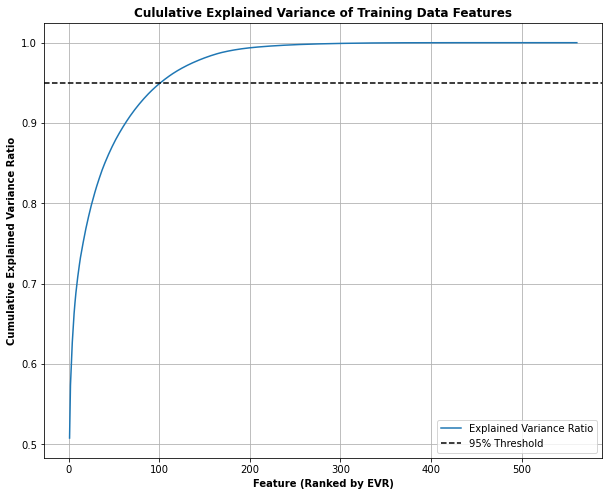

In [33]:
plt.figure(figsize=(10,8))

plt.plot(np.arange(1, 562, 1), np.cumsum(explained_variance_ratio), label='Explained Variance Ratio')
plt.axhline(0.95, color='black', ls='--', label='95% Threshold')
plt.xlabel('Feature (Ranked by EVR)', fontweight='bold')
plt.ylabel('Cumulative Explained Variance Ratio', fontweight='bold')
plt.title('Cululative Explained Variance of Training Data Features', fontweight='bold')
plt.legend()
plt.grid()
plt.show()

As can be seen in the plot above, it looks like almost exactly 100 out of the 561 features in the dataset are needed to explain 95% of its variance. Though this seems like a reasonable number of components to choose, the cell below also checks the performance of the RF model using different numbers of principal components:

In [34]:
pca_components = np.arange(10, 561, 50)
rf_component_scores = []

for pca_component in pca_components:
    pca = PCA(n_components = pca_component)
    tmp_X_train = pca.fit_transform(X_train)
    tmp_X_test = pca.transform(X_test)
    rf = RandomForestClassifier()
    rf.fit(tmp_X_train, y_train)
    preds = rf.predict(tmp_X_test)
    cr = classification_report(y_test, preds, output_dict=True)
    macro_f1 = cr['weighted avg']['f1-score']
    rf_component_scores.append(macro_f1)

The results are plotted below:

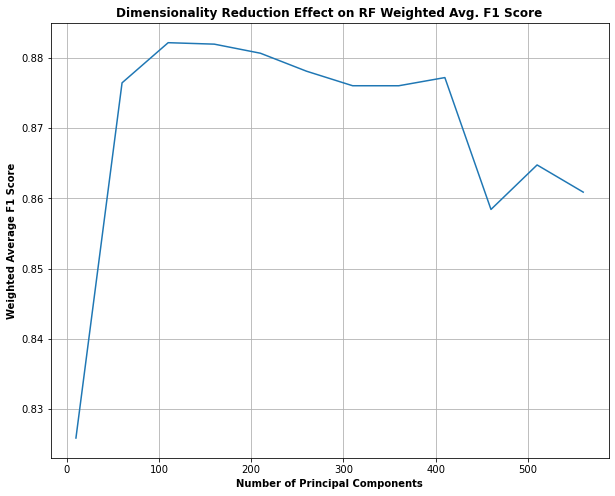

In [35]:
plt.figure(figsize=(10,8))

plt.plot(df_sizes, rf_component_scores)
plt.xlabel('Number of Principal Components', fontweight='bold')
plt.ylabel('Weighted Average F1 Score', fontweight='bold')
plt.title('Dimensionality Reduction Effect on RF Weighted Avg. F1 Score', fontweight='bold')
plt.grid()
plt.show()

As expected, performance shoots up after adding the most important components, but as the number of principal components increases past ~200 the performance actually gets worse. This is likely due to the fact that there is a lot of collinearity between the less significant principal components (these are the features that do not really contribute to the explained variance ratio), making their addition negatively impact the predictive power of the model. 

The cell below scales both the fit times and performance scores to create a plot that shows the impact on both as the number of principal components is changed: 

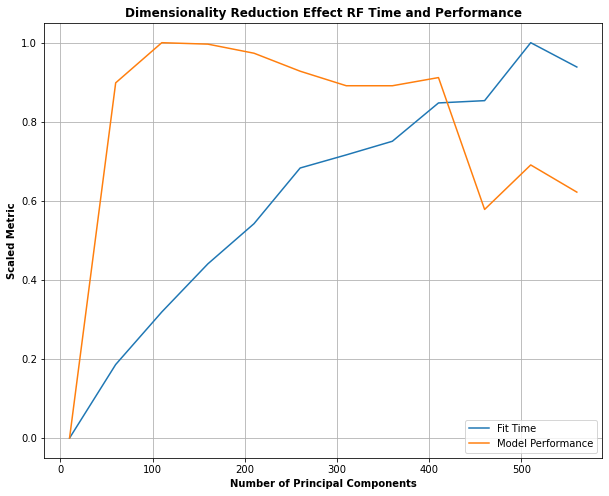

In [36]:
# scale the times and scores so they are both between 0 and 1
scaled_rf_times = (rf_fit_times - np.min(rf_fit_times)) / (np.max(rf_fit_times) - np.min(rf_fit_times))
scaled_rf_scores =  (
    (rf_component_scores - np.min(rf_component_scores)) / 
    (np.max(rf_component_scores) - np.min(rf_component_scores))
)


plt.figure(figsize=(10,8))
plt.plot(df_sizes, scaled_rf_times, label='Fit Time')
plt.plot(df_sizes, scaled_rf_scores, label='Model Performance')
plt.xlabel('Number of Principal Components', fontweight='bold')
plt.ylabel('Scaled Metric', fontweight='bold')
plt.title('Dimensionality Reduction Effect RF Time and Performance', fontweight='bold')
plt.legend()
plt.grid()
plt.show()

Based on the above plot, it appears as though 200 components is enough to approach the highest level of performance, while cutting the fit time almost in half compared to if we had used all components. As such, this will be the number of components used in order to build our RF:

In [37]:
pca = PCA(n_components = 200)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

## Hyperparameter Tuning

Now that we have successfully scaled and reduced our training dataset, we begin the process of actually fine-tuning the RF model. The cell below comes up with a parameter grid that contains multiple different values of the RF's hyperparameters:



In [38]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 6)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

The cell below then uses this parameter grid, along with a `KFold` to perform a `RandomizedSearchCV`, which searches random combinations of the hyperparamters to determine what yields the best results. To make its determination, the grid search will use the weighted average F1 score for each model it tries:

In [ ]:
rf = RandomForestClassifier()
kf = KFold(n_splits=3, shuffle=True, random_state=rs)
rf_cv = RandomizedSearchCV(rf, random_grid, cv=kf, scoring='f1_weighted')
rf_cv.fit(X_train, y_train)

In [ ]:
The cell below prints out the values of the parameters that had the best performance: 

In [ ]:
rf_cv.best_params_

The cell below then uses these best parameters to create our final model: 

In [ ]:
rf = RandomForestClassifier(classweights='balanced', **rf_cv.best_params_)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(xticks_rotation=90)
print(classification_report(y_test, preds))

As we can see in the above output, the result of our efforts is to produce a model that has extremely high performance using less than half of the dataset's original features. 

# Conclusion

The model created above proves that determining human activity via smartphone motion data is entirely possible, and actually quite accurate. The result of the scaling, principal component analysis, and hyperparameter tuning resulted in a random forest model that had a weighted average F1 score of ~, which is a level of performance that most of us would likely be satisfied with if implemented by our actual smartphone devices. 

However, this model could likely be made better by the inclusion of data from participants from different age brackets (<18, >49 years old), and more data in general (only 30 participants were used in this case). Furthermore, additional model tuning and the inclusion of other machine learning techniques (such as gradient boosting) would likely result in even better model performance. 